### **SIR Model Parameters Estimation**

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
np.random.seed(1)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.optimize as optimize
from scipy.interpolate import UnivariateSpline

In [2]:
# est_R_0 = np.array([0.9] * 26)
# est_R_0 = np.random.normal(2, 0.5, size=(26,))
# est_R_0 = np.concatenate((np.random.normal(1, 0.5, size=(13,)), np.random.normal(2, 0.5, size=(13,))), axis=0)
# t_set = np.linspace(0, 765, 766)

def loss_func(est_param, I_true, t_length, type_loss_func, state, plot=False, return_series=False):
    t_set = np.linspace(0, t_length - 1, t_length)

    est_R_0 = est_param[:-1]
    gamma = abs(est_param[-1])

    N_dict = {
        "NJ": 9288994,
        "NY": 20201249,
        "CA": 39538223,
        "IL": 12812508,
        "PA": 13002700
    }

    N = N_dict[state]
    I0, R0 = 20, 0
    S0 = N - I0 - R0
    y0 = S0, I0, R0
    est_R_0 = np.abs(est_R_0)
    
    def random_beta(t):
        idx = int(t//30)
        idx = t_length//30 - 1 if idx >= t_length//30 else idx
        idx = 0 if idx < 0  else idx
        return est_R_0[idx] * gamma
    
    def deriv_dynamic(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = - beta(t) * S * I / N
        dIdt = beta(t) * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    
    ret = odeint(deriv_dynamic, y0, t_set, args=(N, random_beta, gamma))
    S, I, R = ret.T
    
    loss = type_loss_func(I_true, I / N)
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(range(len(I_true)), I_true, label='True')
        ax.plot(range(len(I_true)), I / N, label='Pred')
        plt.legend()
        plt.show()
    
    if return_series:
        return S, I, R
            
    return loss


## Implement the model on five states
#### New Jersey, New York, California, Illinois, Pennsylvania

In [3]:
# Import data 
N_NJ = 9288994
N_NY = 20201249
N_CA = 39538223
N_IL = 12812508
N_PA = 13002700

with open("NJ.txt") as f:
    string_NJ = f.readline()
NJ_data = np.array(string_NJ.split(",")).astype("float")/N_NJ

with open("NY.txt") as f:
    string_NY = f.readline()
NY_data = np.array(string_NJ.split(",")).astype("float")/N_NY

with open("CA.txt") as f:
    string_CA = f.readline()
CA_data = np.array(string_CA.split(",")).astype("float")/N_CA

with open("IL.txt") as f:
    string_IL = f.readline()
IL_data = np.array(string_IL.split(",")).astype("float")/N_IL

with open("PA.txt") as f:
    string_PA = f.readline()
PA_data = np.array(string_PA.split(",")).astype("float")/N_PA

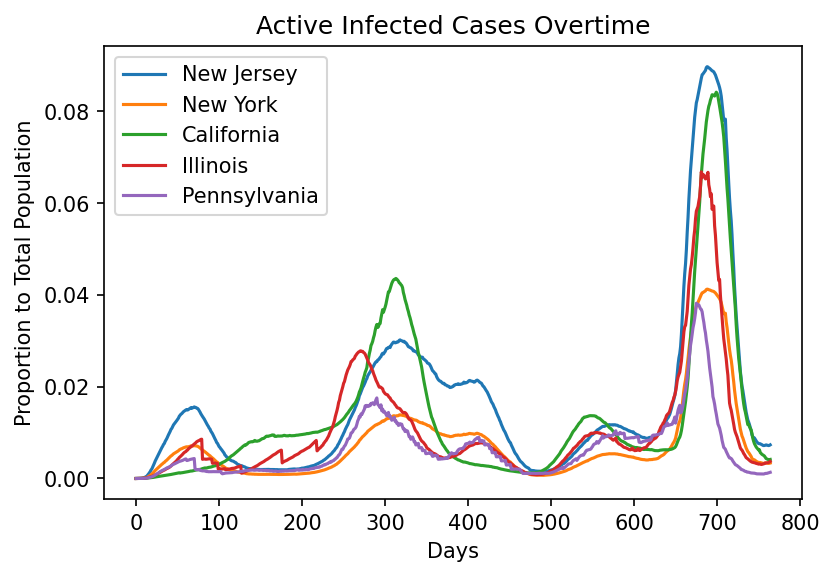

In [4]:
fig, ax = plt.subplots(dpi=150)
ax.plot(NJ_data[:-1], label="New Jersey", alpha=1)
ax.plot(NY_data[:-1], label="New York", alpha=1)
ax.plot(CA_data[:-1], label="California", alpha=1)
ax.plot(IL_data[:-1], label="Illinois", alpha=1)
ax.plot(PA_data[:-1], label="Pennsylvania", alpha=1)
plt.xlabel("Days")
plt.ylabel("Proportion to Total Population")
plt.title("Active Infected Cases Overtime")
plt.legend()
plt.show()

In [5]:
time_period = [180, 320, 265]

#### **New Jersey**

In [34]:
# NJ Period 0
est_param0 = np.concatenate((np.random.normal(1, 1, size=(time_period[0]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_nj0 = optimize.minimize(loss_func, 
                                     est_param0,
                                     args=(NJ_data[:time_period[0]], time_period[0], mean_absolute_error, "NJ"),
                                     method='Nelder-Mead', options={'maxiter':5000, 'disp':True})
optimzer_mse_nj0 = optimize.minimize(loss_func, 
                                     est_param0,
                                     args=(NJ_data[:time_period[0]], time_period[0], mean_squared_error, "NJ"),
                                     method='Nelder-Mead', options={'maxiter':5000, 'disp':True})

Optimization terminated successfully.
         Current function value: 0.000541
         Iterations: 596
         Function evaluations: 926
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 530
         Function evaluations: 832


In [72]:
est_param_mae_nj0 = np.abs(optimzer_mae_nj0.x)
est_r0_mae_nj0 = est_param_mae_nj0[:-1]
est_gamma = est_param_mae_nj0[-1]
S_nj0_mae, I_nj0_mae, R_nj0_mae = loss_func(est_param_mae_nj0, NJ_data[:time_period[0]], time_period[0], 
                             mean_absolute_error, 'NJ', False, True)

In [73]:
est_param_mse_nj0 = np.abs(optimzer_mse_nj0.x)
est_r0_mse_nj0 = est_param_mse_nj0[:-1]
est_gamma = est_param_mse_nj0[-1]
S_nj0_mse, I_nj0_mse, R_nj0_mse = loss_func(est_param_mse_nj0, NJ_data[:time_period[0]], time_period[0], 
                             mean_squared_error, 'NJ', False, True)

In [182]:
# NJ Period 1
est_param1 = np.concatenate((np.random.normal(1, 1, size=(time_period[1]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_nj1 = optimize.minimize(loss_func, 
                                     est_param1,
                                     args=(NJ_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_absolute_error, "NJ"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':10000, 'disp':True})

optimzer_mse_nj1 = optimize.minimize(loss_func, 
                                     est_param1,
                                     args=(NJ_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_squared_error, "NJ"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':10000, 'disp':True})

Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 2067
         Function evaluations: 3101


In [183]:
est_param_mae_nj1 = np.abs(optimzer_mae_nj1.x)
est_r0_mae_nj1 = est_param_mae_nj1[:-1]
est_gamma = est_param_mae_nj1[-1]
S_nj1_mae, I_nj1_mae, R_nj1_mae = loss_func(est_param_mae_nj1, NJ_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], 
                             mean_absolute_error, 'NJ', False, True)

In [184]:
est_param_mse_nj1 = np.abs(optimzer_mse_nj1.x)
est_r0_mse_nj1 = est_param_mse_nj1[:-1]
est_gamma = est_param_mse_nj1[-1]
S_nj1_mse, I_nj1_mse, R_nj1_mse = loss_func(est_param_mse_nj1, NJ_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], 
                             mean_squared_error, 'NJ', False, True)

In [40]:
# NJ Period 2
est_param2 = np.concatenate((np.random.normal(1, 1, size=(time_period[2]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_nj2 = optimize.minimize(loss_func, 
                                     est_param2,
                                     args=(NJ_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_absolute_error, "NJ"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':10000, 'disp':True})

optimzer_mse_nj2 = optimize.minimize(loss_func, 
                                     est_param2, 
                                     args=(NJ_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_squared_error, "NJ"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':10000, 'disp':True})

Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 770
         Function evaluations: 1325


In [76]:
est_param_mae_nj2 = np.abs(optimzer_mae_nj2.x)
est_r0_mae_nj2 = est_param_mae_nj2[:-1]
est_gamma = est_param_mae_nj2[-1]
S_nj2_mae, I_nj2_mae, R_nj2_mae = loss_func(est_param_mae_nj2, NJ_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], 
                             mean_absolute_error, 'NJ', False, True)

In [77]:
est_param_mse_nj2 = np.abs(optimzer_mse_nj2.x)
est_r0_mse_nj2 = est_param_mse_nj2[:-1]
est_gamma = est_param_mse_nj2[-1]
S_nj2_mse, I_nj2_mse, R_nj2_mse = loss_func(est_param_mse_nj2, NJ_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], 
                             mean_squared_error, 'NJ', False, True)

In [185]:
S_nj_mae = np.concatenate((S_nj0_mae, S_nj1_mae, S_nj2_mae))
I_nj_mae = np.concatenate((I_nj0_mae, I_nj1_mae, I_nj2_mae))
R_nj_mae = np.concatenate((R_nj0_mae, R_nj1_mae, R_nj2_mae))
est_r0_nj_mae = np.concatenate((est_r0_mae_nj0, est_r0_mae_nj1, est_r0_mae_nj2))

In [186]:
S_nj_mse = np.concatenate((S_nj0_mse, S_nj1_mse, S_nj2_mse))
I_nj_mse = np.concatenate((I_nj0_mse, I_nj1_mse, I_nj2_mse))
R_nj_mse = np.concatenate((R_nj0_mse, R_nj1_mse, R_nj2_mse))
est_r0_nj_mse = np.concatenate((est_r0_mse_nj0, est_r0_mse_nj1, est_r0_mse_nj2))

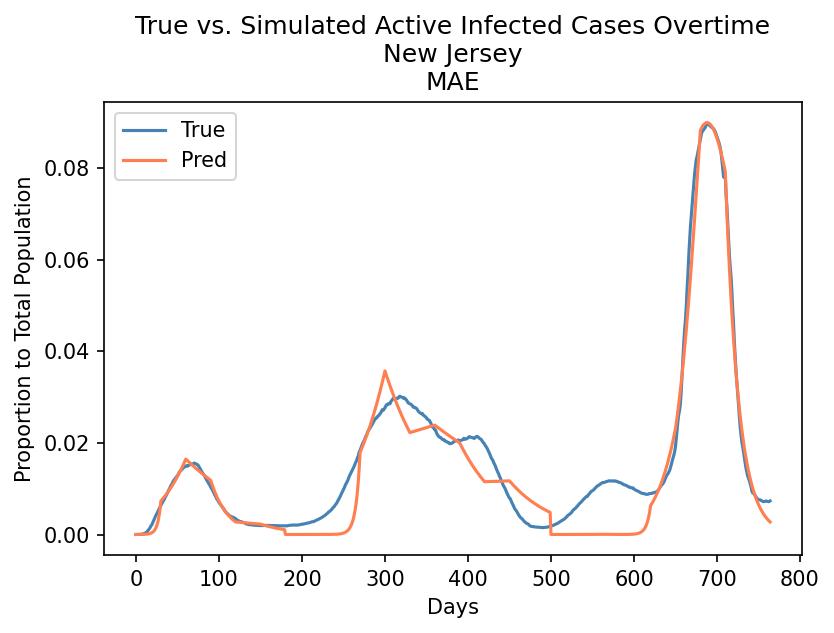

In [187]:
fig, ax = plt.subplots(dpi=150)
ax.plot(range(len(I_nj_mae)), NJ_data[:-1], label="True", color='steelblue', alpha=1)
ax.plot(range(len(I_nj_mae)), I_nj_mae / N_NJ, label="Pred", color='coral')
plt.xlabel("Days")
plt.ylabel("Proportion to Total Population")
plt.title("True vs. Simulated Active Infected Cases Overtime\nNew Jersey\nMAE")
plt.legend()
plt.show()

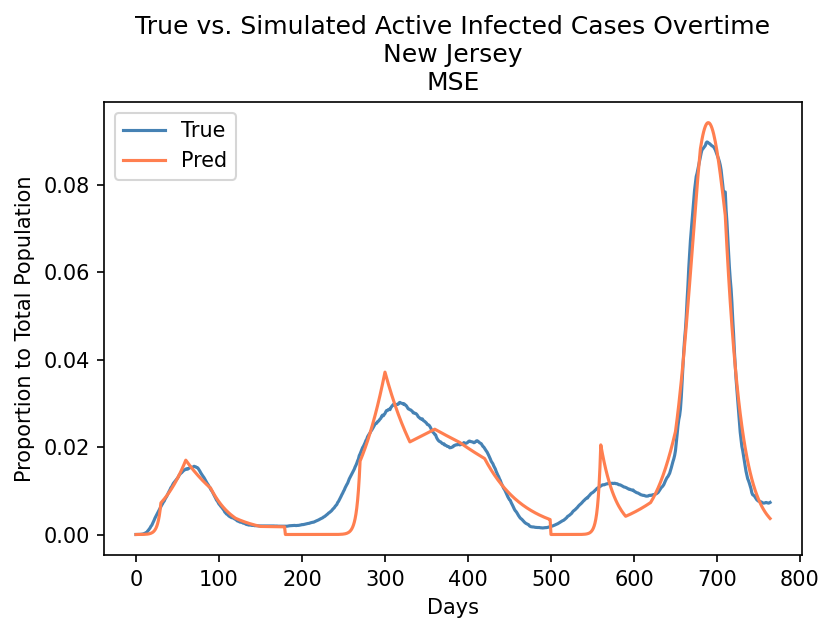

In [188]:
fig, ax = plt.subplots(dpi=150)
ax.plot(range(len(I_nj_mse)), NJ_data[:-1], label="True", color='steelblue', alpha=1)
ax.plot(range(len(I_nj_mse)), I_nj_mse / N_NJ, label="Pred", color='coral')
plt.xlabel("Days")
plt.ylabel("Proportion to Total Population")
plt.title("True vs. Simulated Active Infected Cases Overtime\nNew Jersey\nMSE")
plt.legend()
plt.show()

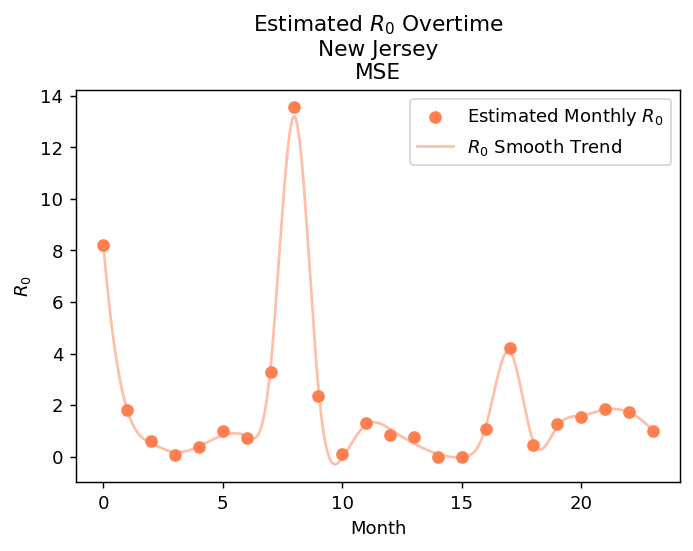

In [191]:
spl = UnivariateSpline(list(range(len(est_r0_nj_mse))), est_r0_nj_mse, k=3)
spl.set_smoothing_factor(0.5)
full_period = np.linspace(0, 23, 2000)
smoothed_est_r0 = spl(full_period)

fig, ax = plt.subplots(dpi=130)
ax.scatter(range(len(est_r0_nj_mse)), est_r0_nj_mse, color="coral", label="Estimated Monthly $R_0$")
ax.plot(full_period, smoothed_est_r0, color="coral", label="$R_0$ Smooth Trend", alpha=0.5)
plt.xlabel("Month")
plt.ylabel("$R_0$")
plt.title("Estimated $R_0$ Overtime\nNew Jersey\nMSE")
plt.legend()
plt.show()

#### **New York**

In [170]:
# NY Period 0
est_param0 = np.concatenate((np.random.normal(1, 1, size=(time_period[0]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_ny0 = optimize.minimize(loss_func, 
                                     est_param0,
                                     args=(NY_data[:time_period[0]], time_period[0], mean_absolute_error, "NY"),
                                     tol=1e-20,
                                     method='Nelder-Mead', options={'maxiter':5000, 'disp':True})
optimzer_mse_ny0 = optimize.minimize(loss_func, 
                                     est_param0,
                                     args=(NY_data[:time_period[0]], time_period[0], mean_squared_error, "NY"),
                                     tol=1e-20,
                                     method='Nelder-Mead', options={'maxiter':5000, 'disp':True})

est_param_mae_ny0 = np.abs(optimzer_mae_ny0.x)
est_r0_mae_ny0 = est_param_mae_ny0[:-1]
est_gamma = est_param_mae_ny0[-1]
S_ny0_mae, I_ny0_mae, R_ny0_mae = loss_func(est_param_mae_ny0, NY_data[:time_period[0]], time_period[0], 
                             mean_absolute_error, 'NY', False, True)

est_param_mse_ny0 = np.abs(optimzer_mse_ny0.x)
est_r0_mse_ny0 = est_param_mse_ny0[:-1]
est_gamma = est_param_mse_ny0[-1]
S_ny0_mse, I_ny0_mse, R_ny0_mse = loss_func(est_param_mse_ny0, NY_data[:time_period[0]], time_period[0], 
                             mean_squared_error, 'NY', False, True)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 921
         Function evaluations: 1661


In [163]:
# NY Period 1
est_param1 = np.concatenate((np.random.normal(1, 1, size=(time_period[1]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_ny1 = optimize.minimize(loss_func, 
                                     est_param1,
                                     args=(NY_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_absolute_error, "NY"), 
                                     method='Nelder-Mead',
                                     tol=1e-3,
                                     options={'maxiter':10000, 'disp':True})

optimzer_mse_ny1 = optimize.minimize(loss_func, 
                                     est_param1,
                                     args=(NY_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_squared_error, "NY"), 
                                     method='Nelder-Mead',
                                     tol=1e-3,
                                     options={'maxiter':10000, 'disp':True})

est_param_mae_ny1 = np.abs(optimzer_mae_ny1.x)
est_r0_mae_ny1 = est_param_mae_ny1[:-1]
est_gamma = est_param_mae_ny1[-1]
S_ny1_mae, I_ny1_mae, R_ny1_mae = loss_func(est_param_mae_ny1, NY_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], 
                             mean_absolute_error, 'NY', False, True)

est_param_mse_ny1 = np.abs(optimzer_mse_ny1.x)
est_r0_mse_ny1 = est_param_mse_ny1[:-1]
est_gamma = est_param_mse_ny1[-1]
S_ny1_mse, I_ny1_mse, R_ny1_mse = loss_func(est_param_mse_ny1, NY_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], 
                             mean_squared_error, 'NY', False, True)

Optimization terminated successfully.
         Current function value: 0.001048
         Iterations: 704
         Function evaluations: 1017
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1283
         Function evaluations: 1770


In [84]:
# NY Period 2
est_param2 = np.concatenate((np.random.normal(1, 1, size=(time_period[2]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_ny2 = optimize.minimize(loss_func, 
                                     est_param2,
                                     args=(NY_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_absolute_error, "NY"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':10000, 'disp':True})

optimzer_mse_ny2 = optimize.minimize(loss_func, 
                                     est_param2, 
                                     args=(NY_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_squared_error, "NY"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':10000, 'disp':True})

est_param_mae_ny2 = np.abs(optimzer_mae_ny2.x)
est_r0_mae_ny2 = est_param_mae_ny2[:-1]
est_gamma = est_param_mae_ny2[-1]
S_ny2_mae, I_ny2_mae, R_ny2_mae = loss_func(est_param_mae_ny2, NY_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], 
                             mean_absolute_error, 'NY', False, True)

est_param_mse_ny2 = np.abs(optimzer_mse_ny2.x)
est_r0_mse_ny2 = est_param_mse_ny2[:-1]
est_gamma = est_param_mse_ny2[-1]
S_ny2_mse, I_ny2_mse, R_ny2_mse = loss_func(est_param_mse_ny2, NY_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], 
                             mean_squared_error, 'NY', False, True)

Optimization terminated successfully.
         Current function value: 0.001893
         Iterations: 966
         Function evaluations: 1572
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 1366
         Function evaluations: 2175


In [171]:
S_ny_mae = np.concatenate((S_ny0_mae, S_ny1_mae, S_ny2_mae))
I_ny_mae = np.concatenate((I_ny0_mae, I_ny1_mae, I_ny2_mae))
R_ny_mae = np.concatenate((R_ny0_mae, R_ny1_mae, R_ny2_mae))
est_r0_ny_mae = np.concatenate((est_r0_mae_ny0, est_r0_mae_ny1, est_r0_mae_ny2))

S_ny_mse = np.concatenate((S_ny0_mse, S_ny1_mse, S_ny2_mse))
I_ny_mse = np.concatenate((I_ny0_mse, I_ny1_mse, I_ny2_mse))
R_ny_mse = np.concatenate((R_ny0_mse, R_ny1_mse, R_ny2_mse))
est_r0_ny_mse = np.concatenate((est_r0_mse_ny0, est_r0_mse_ny1, est_r0_mse_ny2))

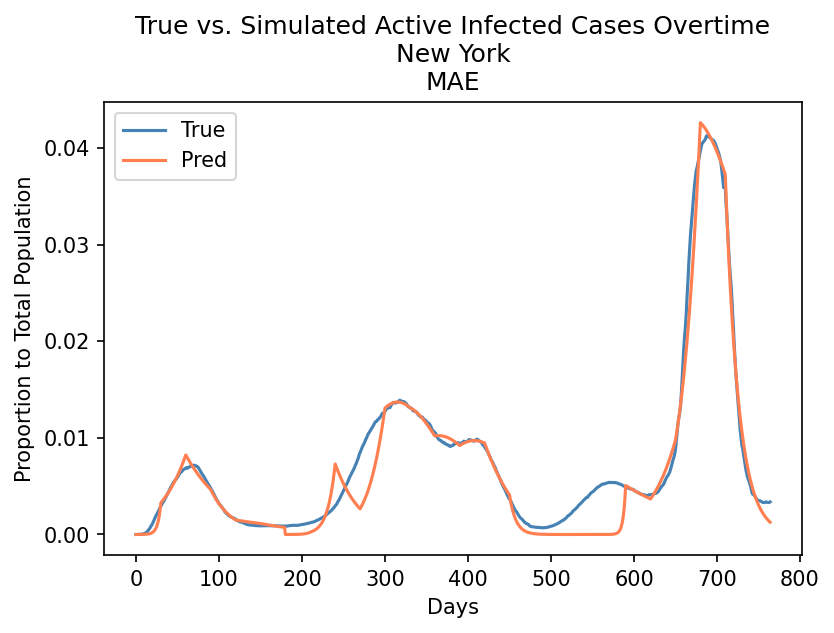

In [172]:
fig, ax = plt.subplots(dpi=150)
ax.plot(range(len(I_ny_mae)), NY_data[:-1], label="True", color='steelblue', alpha=1)
ax.plot(range(len(I_ny_mae)), I_ny_mae / N_NY, label="Pred", color='coral')
plt.xlabel("Days")
plt.ylabel("Proportion to Total Population")
plt.title("True vs. Simulated Active Infected Cases Overtime\nNew York\nMAE")
plt.legend()
plt.show()

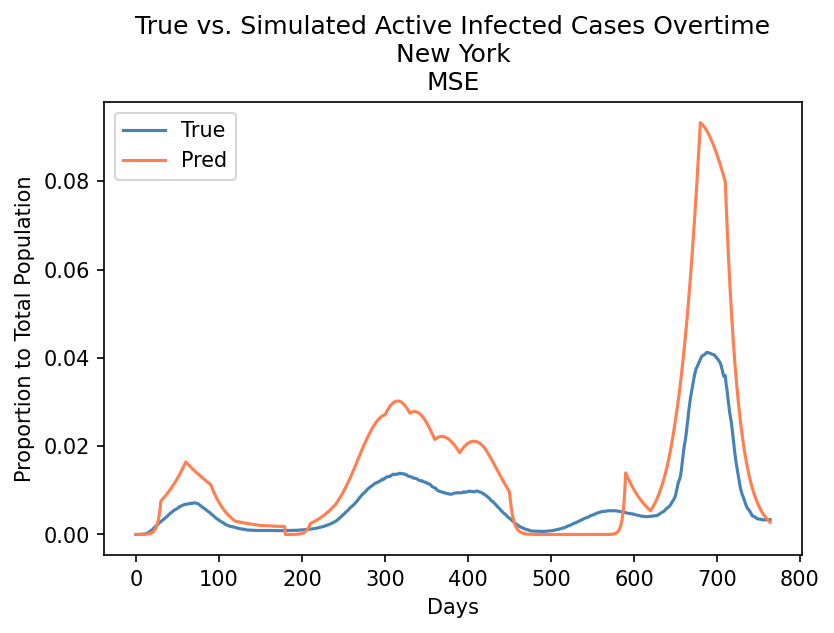

In [174]:
fig, ax = plt.subplots(dpi=150)
ax.plot(range(len(I_ny_mse)), NY_data[:-1], label="True", color='steelblue', alpha=1)
ax.plot(range(len(I_ny_mse)), I_ny_mse / N_NJ, label="Pred", color='coral')
plt.xlabel("Days")
plt.ylabel("Proportion to Total Population")
plt.title("True vs. Simulated Active Infected Cases Overtime\nNew York\nMSE")
plt.legend()
plt.show()

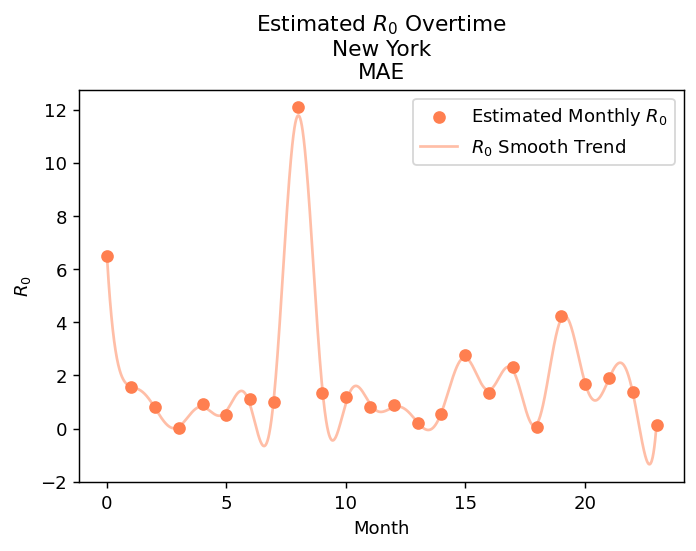

In [128]:
spl = UnivariateSpline(list(range(len(est_r0_nj_mae))), est_r0_nj_mae, k=5)
spl.set_smoothing_factor(0.5)
full_period = np.linspace(0, 23, 2000)
smoothed_est_r0 = spl(full_period)

fig, ax = plt.subplots(dpi=130)
ax.scatter(range(len(est_r0_nj_mae)), est_r0_nj_mae, color="coral", label="Estimated Monthly $R_0$")
ax.plot(full_period, smoothed_est_r0, color="coral", label="$R_0$ Smooth Trend", alpha=0.5)
plt.xlabel("Month")
plt.ylabel("$R_0$")
plt.title("Estimated $R_0$ Overtime\nNew York\nMAE")
plt.legend()
plt.show()

#### **California**

In [89]:
# CA Period 0
est_param0 = np.concatenate((np.random.normal(1, 1, size=(time_period[0]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_ca0 = optimize.minimize(loss_func, 
                                     est_param0,
                                     args=(CA_data[:time_period[0]], time_period[0], mean_absolute_error, "CA"),
                                     method='Nelder-Mead', options={'maxiter':5000, 'disp':True})
optimzer_mse_ca0 = optimize.minimize(loss_func, 
                                     est_param0,
                                     args=(CA_data[:time_period[0]], time_period[0], mean_squared_error, "CA"),
                                     method='Nelder-Mead', options={'maxiter':5000, 'disp':True})

est_param_mae_ca0 = np.abs(optimzer_mae_ca0.x)
est_r0_mae_ca0 = est_param_mae_ca0[:-1]
est_gamma = est_param_mae_ca0[-1]
S_ca0_mae, I_ca0_mae, R_ca0_mae = loss_func(est_param_mae_ca0, CA_data[:time_period[0]], time_period[0], 
                             mean_absolute_error, 'CA', False, True)

est_param_mse_ca0 = np.abs(optimzer_mse_ca0.x)
est_r0_mse_ca0 = est_param_mse_ca0[:-1]
est_gamma = est_param_mse_ca0[-1]
S_ca0_mse, I_ca0_mse, R_ca0_mse = loss_func(est_param_mse_ca0, CA_data[:time_period[0]], time_period[0], 
                             mean_squared_error, 'CA', False, True)

Optimization terminated successfully.
         Current function value: 0.000216
         Iterations: 667
         Function evaluations: 1015
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 969
         Function evaluations: 1471


In [90]:
# CA Period 1
est_param1 = np.concatenate((np.random.normal(1, 1, size=(time_period[1]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_ca1 = optimize.minimize(loss_func, 
                                     est_param1,
                                     args=(CA_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_absolute_error, "CA"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':5000, 'disp':True})

optimzer_mse_ca1 = optimize.minimize(loss_func, 
                                     est_param1,
                                     args=(CA_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_squared_error, "CA"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':5000, 'disp':True})

est_param_mae_ca1 = np.abs(optimzer_mae_ca1.x)
est_r0_mae_ca1 = est_param_mae_ca1[:-1]
est_gamma = est_param_mae_ca1[-1]
S_ca1_mae, I_ca1_mae, R_ca1_mae = loss_func(est_param_mae_ca1, CA_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], 
                             mean_absolute_error, 'CA', False, True)

est_param_mse_ca1 = np.abs(optimzer_mse_ca1.x)
est_r0_mse_ca1 = est_param_mse_ca1[:-1]
est_gamma = est_param_mse_ca1[-1]
S_ca1_mse, I_ca1_mse, R_ca1_mse = loss_func(est_param_mse_ca1, CA_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], 
                             mean_squared_error, 'CA', False, True)

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 2833
         Function evaluations: 4165


In [91]:
# CA Period 2
est_param2 = np.concatenate((np.random.normal(1, 1, size=(time_period[2]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_ca2 = optimize.minimize(loss_func, 
                                     est_param2,
                                     args=(CA_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_absolute_error, "CA"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':10000, 'disp':True})

optimzer_mse_ca2 = optimize.minimize(loss_func, 
                                     est_param2, 
                                     args=(CA_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_squared_error, "CA"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':10000, 'disp':True})

est_param_mae_ca2 = np.abs(optimzer_mae_ca2.x)
est_r0_mae_ca2 = est_param_mae_ca2[:-1]
est_gamma = est_param_mae_ca2[-1]
S_ca2_mae, I_ca2_mae, R_ca2_mae = loss_func(est_param_mae_ca2, CA_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], 
                             mean_absolute_error, 'CA', False, True)

est_param_mse_ca2 = np.abs(optimzer_mse_ca2.x)
est_r0_mse_ca2 = est_param_mse_ca2[:-1]
est_gamma = est_param_mse_ca2[-1]
S_ca2_mse, I_ca2_mse, R_ca2_mse = loss_func(est_param_mse_ca2, CA_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], 
                             mean_squared_error, 'CA', False, True)

Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 1015
         Function evaluations: 1705


In [92]:
S_ca_mae = np.concatenate((S_ca0_mae, S_ca1_mae, S_ca2_mae))
I_ca_mae = np.concatenate((I_ca0_mae, I_ca1_mae, I_ca2_mae))
R_ca_mae = np.concatenate((R_ca0_mae, R_ca1_mae, R_ca2_mae))
est_r0_ca_mae = np.concatenate((est_r0_mae_ca0, est_r0_mae_ca1, est_r0_mae_ca2))

S_ca_mse = np.concatenate((S_ca0_mse, S_ca1_mse, S_ca2_mse))
I_ca_mse = np.concatenate((I_ca0_mse, I_ca1_mse, I_ca2_mse))
R_ca_mse = np.concatenate((R_ca0_mse, R_ca1_mse, R_ca2_mse))
est_r0_ca_mse = np.concatenate((est_r0_mse_ca0, est_r0_mse_ca1, est_r0_mse_ca2))

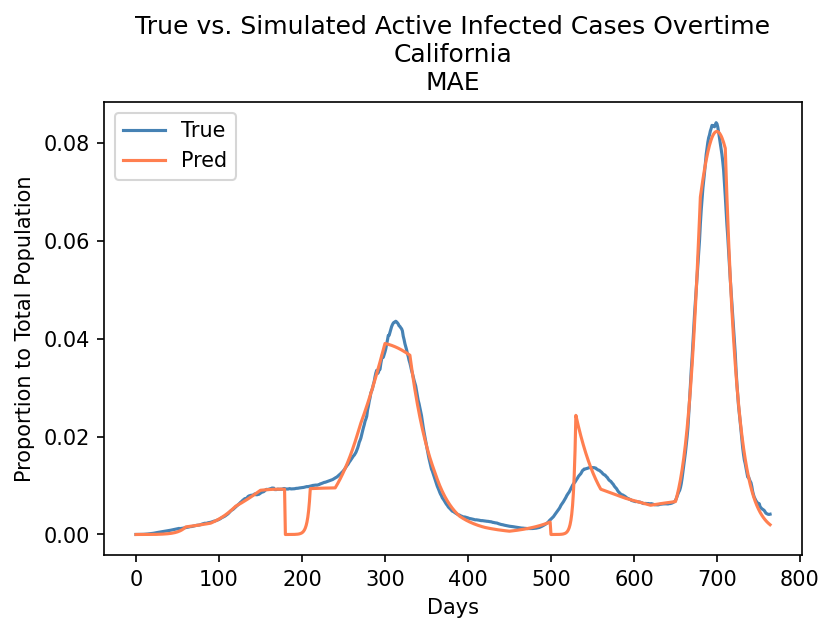

In [95]:
fig, ax = plt.subplots(dpi=150)
ax.plot(range(len(I_ca_mae)), CA_data[:-1], label="True", color='steelblue', alpha=1)
ax.plot(range(len(I_ca_mae)), I_ca_mae / N_CA, label="Pred", color='coral')
plt.xlabel("Days")
plt.ylabel("Proportion to Total Population")
plt.title("True vs. Simulated Active Infected Cases Overtime\nCalifornia\nMAE")
plt.legend()
plt.show()

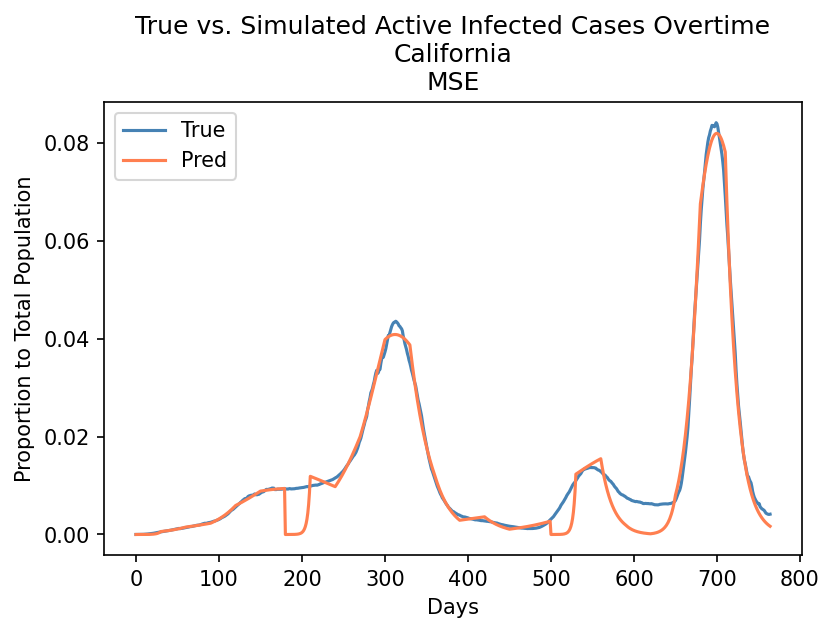

In [94]:
fig, ax = plt.subplots(dpi=150)
ax.plot(range(len(I_ca_mse)), CA_data[:-1], label="True", color='steelblue', alpha=1)
ax.plot(range(len(I_ca_mse)), I_ca_mse / N_CA, label="Pred", color='coral')
plt.xlabel("Days")
plt.ylabel("Proportion to Total Population")
plt.title("True vs. Simulated Active Infected Cases Overtime\nCalifornia\nMSE")
plt.legend()
plt.show()

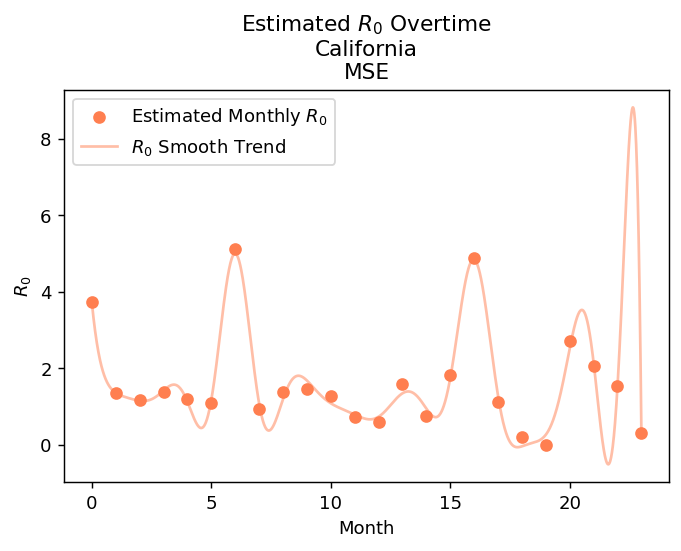

In [98]:
spl = UnivariateSpline(list(range(len(est_r0_ca_mse))), est_r0_ca_mse, k=5)
spl.set_smoothing_factor(0.5)
full_period = np.linspace(0, 23, 2000)
smoothed_est_r0 = spl(full_period)

fig, ax = plt.subplots(dpi=130)
ax.scatter(range(len(est_r0_ca_mse)), est_r0_ca_mse, color="coral", label="Estimated Monthly $R_0$")
ax.plot(full_period, smoothed_est_r0, color="coral", label="$R_0$ Smooth Trend", alpha=0.5)
plt.xlabel("Month")
plt.ylabel("$R_0$")
plt.title("Estimated $R_0$ Overtime\nCalifornia\nMSE")
plt.legend()
plt.show()

#### **Illinois**

In [101]:
# IL Period 0
est_param0 = np.concatenate((np.random.normal(1, 1, size=(time_period[0]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_il0 = optimize.minimize(loss_func, 
                                     est_param0,
                                     args=(IL_data[:time_period[0]], time_period[0], mean_absolute_error, "IL"),
                                     method='Nelder-Mead', options={'maxiter':5000, 'disp':True})
optimzer_mse_il0 = optimize.minimize(loss_func, 
                                     est_param0,
                                     args=(IL_data[:time_period[0]], time_period[0], mean_squared_error, "IL"),
                                     method='Nelder-Mead', options={'maxiter':5000, 'disp':True})

est_param_mae_il0 = np.abs(optimzer_mae_il0.x)
est_r0_mae_il0 = est_param_mae_il0[:-1]
est_gamma = est_param_mae_il0[-1]
S_il0_mae, I_il0_mae, R_il0_mae = loss_func(est_param_mae_il0, IL_data[:time_period[0]], time_period[0], 
                             mean_absolute_error, 'IL', False, True)

est_param_mse_il0 = np.abs(optimzer_mse_il0.x)
est_r0_mse_il0 = est_param_mse_il0[:-1]
est_gamma = est_param_mse_il0[-1]
S_il0_mse, I_il0_mse, R_il0_mse = loss_func(est_param_mse_il0, IL_data[:time_period[0]], time_period[0], 
                             mean_squared_error, 'IL', False, True)

Optimization terminated successfully.
         Current function value: 0.001311
         Iterations: 1007
         Function evaluations: 1526
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 1473
         Function evaluations: 2219


In [141]:
# IL Period 1
est_param1 = np.concatenate((np.random.normal(1, 1, size=(time_period[1]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_il1 = optimize.minimize(loss_func, 
                                     est_param1,
                                     args=(IL_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_absolute_error, "IL"), 
                                     method='Nelder-Mead',
                                     tol=1e-20,
                                     options={'maxiter':10000, 'disp':True})

optimzer_mse_il1 = optimize.minimize(loss_func, 
                                     est_param1,
                                     args=(IL_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_squared_error, "IL"), 
                                     method='Nelder-Mead',
                                     tol=1e-20,
                                     options={'maxiter':10000, 'disp':True})

est_param_mae_il1 = np.abs(optimzer_mae_il1.x)
est_r0_mae_il1 = est_param_mae_il1[:-1]
est_gamma = est_param_mae_il1[-1]
S_il1_mae, I_il1_mae, R_il1_mae = loss_func(est_param_mae_il1, IL_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], 
                             mean_absolute_error, 'IL', False, True)

est_param_mse_il1 = np.abs(optimzer_mse_il1.x)
est_r0_mse_il1 = est_param_mse_il1[:-1]
est_gamma = est_param_mse_il1[-1]
S_il1_mse, I_il1_mse, R_il1_mse = loss_func(est_param_mse_il1, IL_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], 
                             mean_squared_error, 'IL', False, True)

In [137]:
# IL Period 2
et_param2 = np.concatenate((np.random.normal(1, 1, size=(time_period[2]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_il2 = optimize.minimize(loss_func, 
                                     est_param2,
                                     args=(IL_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_absolute_error, "IL"), 
                                     method='Nelder-Mead',
                                     tol=1e-20,
                                     options={'maxiter':15000, 'disp':True})

optimzer_mse_il2 = optimize.minimize(loss_func, 
                                     est_param2, 
                                     args=(IL_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_squared_error, "IL"), 
                                     method='Nelder-Mead',
                                     tol=1e-20,
                                     options={'maxiter':15000, 'disp':True})

est_param_mae_il2 = np.abs(optimzer_mae_il2.x)
est_r0_mae_il2 = est_param_mae_il2[:-1]
est_gamma = est_param_mae_il2[-1]
S_il2_mae, I_il2_mae, R_il2_mae = loss_func(est_param_mae_il2, IL_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], 
                             mean_absolute_error, 'IL', False, True)

est_param_mse_il2 = np.abs(optimzer_mse_il2.x)
est_r0_mse_il2 = est_param_mse_il2[:-1]
est_gamma = est_param_mse_il2[-1]
S_il2_mse, I_il2_mse, R_il2_mse = loss_func(est_param_mse_il2, IL_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], 
                             mean_squared_error, 'IL', False, True)

In [148]:
S_il_mae = np.concatenate((S_il0_mae, S_il1_mae, S_il2_mae))
I_il_mae = np.concatenate((I_il0_mae, I_il1_mae, I_il2_mae))
R_il_mae = np.concatenate((R_il0_mae, R_il1_mae, R_il2_mae))
est_r0_il_mae = np.concatenate((est_r0_mae_il0, est_r0_mae_il1, est_r0_mae_il2))

S_il_mse = np.concatenate((S_il0_mse, S_il1_mse, S_il2_mse))
I_il_mse = np.concatenate((I_il0_mse, I_il1_mse, I_il2_mse))
R_il_mse = np.concatenate((R_il0_mse, R_il1_mse, R_il2_mse))
est_r0_il_mse = np.concatenate((est_r0_mse_il0, est_r0_mse_il1, est_r0_mse_il2))

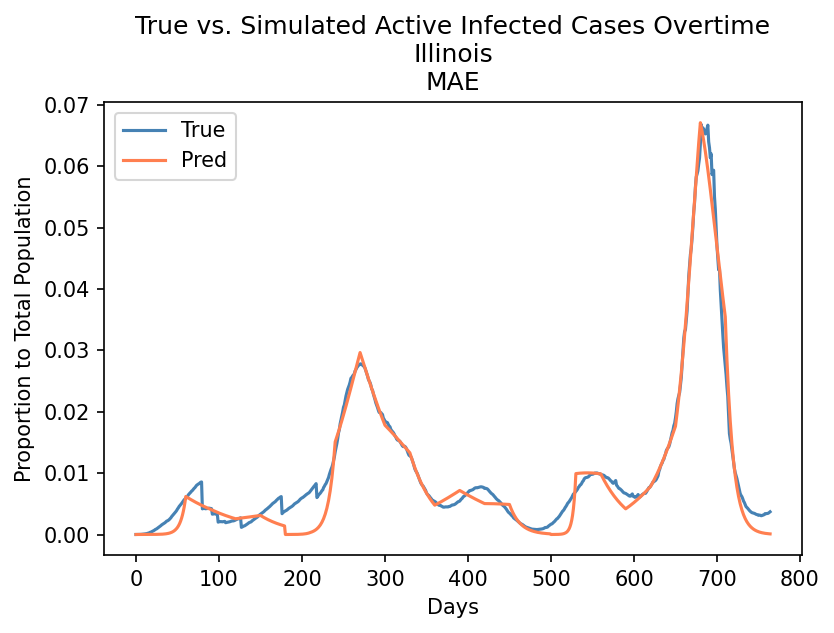

In [144]:
fig, ax = plt.subplots(dpi=150)
ax.plot(range(len(I_il_mae)), IL_data[:-1], label="True", color='steelblue', alpha=1)
ax.plot(range(len(I_il_mae)), I_il_mae / N_IL, label="Pred", color='coral')
plt.xlabel("Days")
plt.ylabel("Proportion to Total Population")
plt.title("True vs. Simulated Active Infected Cases Overtime\nIllinois\nMAE")
plt.legend()
plt.show()

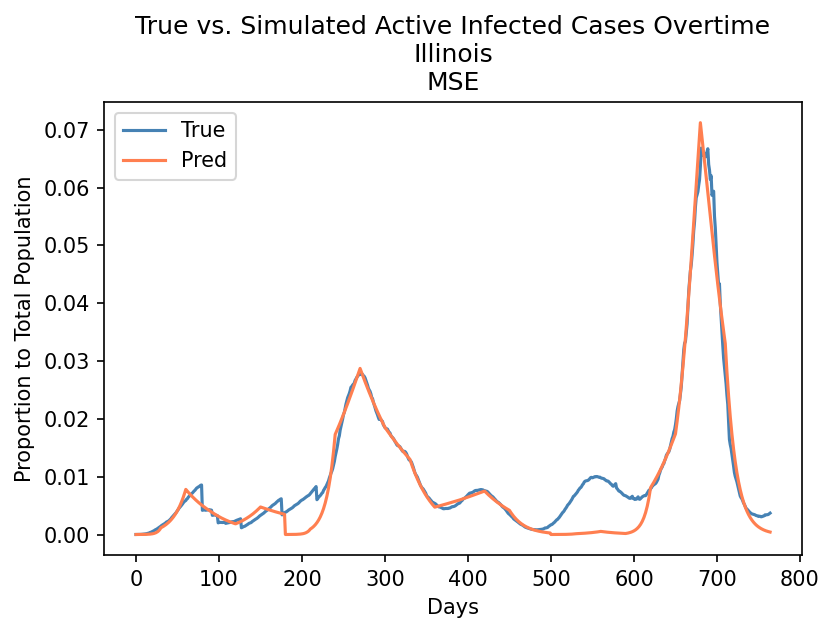

In [145]:
fig, ax = plt.subplots(dpi=150)
ax.plot(range(len(I_il_mse)), IL_data[:-1], label="True", color='steelblue', alpha=1)
ax.plot(range(len(I_il_mse)), I_il_mse / N_IL, label="Pred", color='coral')
plt.xlabel("Days")
plt.ylabel("Proportion to Total Population")
plt.title("True vs. Simulated Active Infected Cases Overtime\nIllinois\nMSE")
plt.legend()
plt.show()

In [151]:
est_r0_il_mae

array([3.82252701, 5.35035673, 0.64692217, 0.60416783, 1.18489393,
       0.28973603, 2.92525589, 2.39218861, 1.32279775, 0.94002622,
       1.08662677, 0.79259424, 1.46566074, 1.1422491 , 1.3188854 ,
       0.21524777, 3.65373963, 1.02975808, 0.78423764, 1.28386772,
       1.39660947, 1.78277192, 1.34798912, 0.02186971])

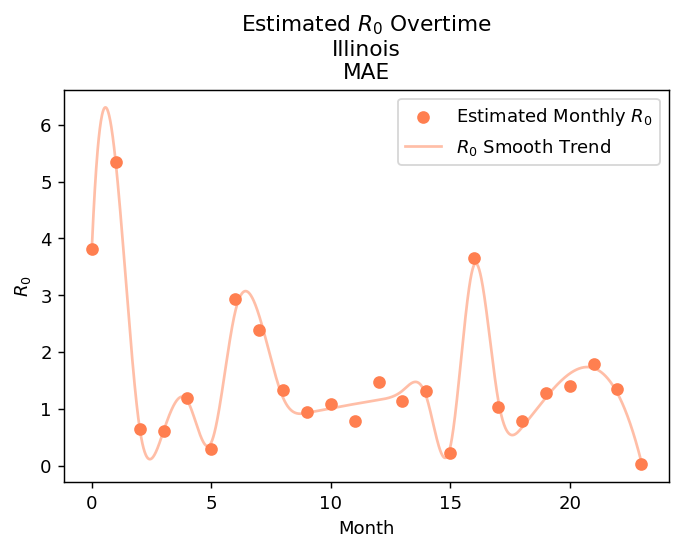

In [158]:
spl = UnivariateSpline(list(range(len(est_r0_il_mae))), est_r0_il_mae, k=3)
spl.set_smoothing_factor(0.5)
full_period = np.linspace(0, 23, 2000)
smoothed_est_r0 = spl(full_period)

fig, ax = plt.subplots(dpi=130)
ax.scatter(range(len(est_r0_il_mae)), est_r0_il_mae, color="coral", label="Estimated Monthly $R_0$")
ax.plot(full_period, smoothed_est_r0, color="coral", label="$R_0$ Smooth Trend", alpha=0.5)
plt.xlabel("Month")
plt.ylabel("$R_0$")
plt.title("Estimated $R_0$ Overtime\nIllinois\nMAE")
plt.legend()
plt.show()

#### **Pennsylvania**

In [33]:
# PA Period 0
est_param0 = np.concatenate((np.random.normal(1, 1, size=(time_period[0]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_pa0 = optimize.minimize(loss_func, 
                                     est_param0,
                                     args=(PA_data[:time_period[0]], time_period[0], mean_absolute_error, "PA"),
                                     method='Nelder-Mead', 
                                     tol=1e-7,
                                     options={'maxiter':5000, 'disp':True})
optimzer_mse_pa0 = optimize.minimize(loss_func, 
                                     est_param0,
                                     args=(PA_data[:time_period[0]], time_period[0], mean_squared_error, "PA"),
                                     tol=1e-7,
                                     method='Nelder-Mead', options={'maxiter':5000, 'disp':True})


Optimization terminated successfully.
         Current function value: 0.000937
         Iterations: 1188
         Function evaluations: 1862
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1094
         Function evaluations: 1713


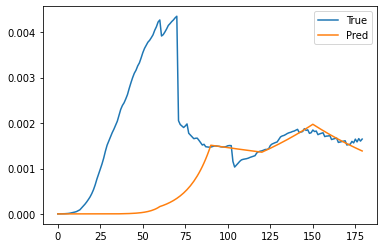

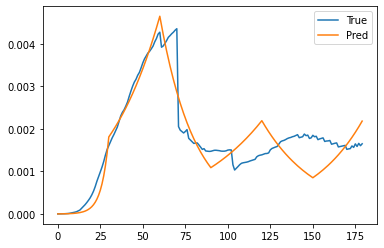

In [34]:
est_param_mae_pa0 = np.abs(optimzer_mae_pa0.x)
est_r0_mae_pa0 = est_param_mae_pa0[:-1]
est_gamma = est_param_mae_pa0[-1]
S_pa0_mae, I_pa0_mae, R_pa0_mae = loss_func(est_param_mae_pa0, PA_data[:time_period[0]], time_period[0], 
                             mean_absolute_error, 'PA', True, True)

est_param_mse_pa0 = np.abs(optimzer_mse_pa0.x)
est_r0_mse_pa0 = est_param_mse_pa0[:-1]
est_gamma = est_param_mse_pa0[-1]
S_pa0_mse, I_pa0_mse, R_pa0_mse = loss_func(est_param_mse_pa0, PA_data[:time_period[0]], time_period[0], 
                             mean_squared_error, 'PA', True, True)

In [18]:
# PA Period 1
est_param1 = np.concatenate((np.random.normal(1, 1, size=(time_period[1]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_pa1 = optimize.minimize(loss_func, 
                                     est_param1,
                                     args=(PA_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_absolute_error, "PA"), 
                                     method='Nelder-Mead',
                                     tol=1e-3,
                                     options={'maxiter':5000, 'disp':True})

optimzer_mse_pa1 = optimize.minimize(loss_func, 
                                     est_param1,
                                     args=(PA_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_squared_error, "PA"), 
                                     method='Nelder-Mead',
                                     tol=1e-3,
                                     options={'maxiter':5000, 'disp':True})

Optimization terminated successfully.
         Current function value: 0.000891
         Iterations: 2900
         Function evaluations: 3986
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 1434
         Function evaluations: 2005


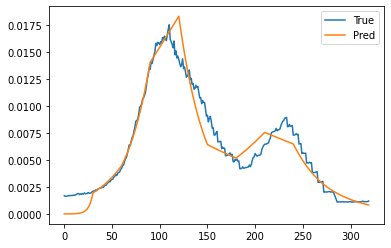

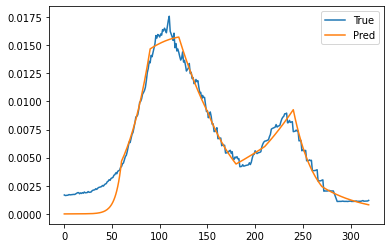

In [20]:
est_param_mae_pa1 = np.abs(optimzer_mae_pa1.x)
est_r0_mae_pa1 = est_param_mae_pa1[:-1]
est_gamma = est_param_mae_pa1[-1]
S_pa1_mae, I_pa1_mae, R_pa1_mae = loss_func(est_param_mae_pa1, PA_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], 
                                            mean_absolute_error, 'PA', True, True)

est_param_mse_pa1 = np.abs(optimzer_mse_pa1.x)
est_r0_mse_pa1 = est_param_mse_pa1[:-1]
est_gamma = est_param_mse_pa1[-1]
S_pa1_mse, I_pa1_mse, R_pa1_mse = loss_func(est_param_mse_pa1, PA_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], 
                                            mean_squared_error, 'PA', True, True)

In [27]:
# PA Period 2
est_param2 = np.concatenate((np.random.normal(1, 1, size=(time_period[2]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_pa2 = optimize.minimize(loss_func, 
                                     est_param2,
                                     args=(PA_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_absolute_error, "PA"), 
                                     method='Nelder-Mead',
                                     tol=1e-9,
                                     options={'maxiter':10000, 'disp':True})

optimzer_mse_pa2 = optimize.minimize(loss_func, 
                                     est_param2, 
                                     args=(PA_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_squared_error, "PA"), 
                                     method='Nelder-Mead',
                                     tol=1e-9,
                                     options={'maxiter':10000, 'disp':True})

Optimization terminated successfully.
         Current function value: 0.004134
         Iterations: 1412
         Function evaluations: 2194
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 1818
         Function evaluations: 2751


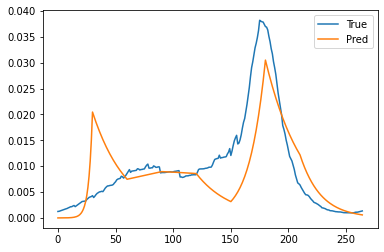

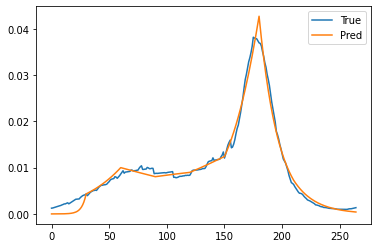

In [28]:
est_param_mae_pa2 = np.abs(optimzer_mae_pa2.x)
est_r0_mae_pa2 = est_param_mae_pa2[:-1]
est_gamma = est_param_mae_pa2[-1]
S_pa2_mae, I_pa2_mae, R_pa2_mae = loss_func(est_param_mae_pa2, PA_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], 
                             mean_absolute_error, 'PA', True, True)

est_param_mse_pa2 = np.abs(optimzer_mse_pa2.x)
est_r0_mse_pa2 = est_param_mse_pa2[:-1]
est_gamma = est_param_mse_pa2[-1]
S_pa2_mse, I_pa2_mse, R_pa2_mse = loss_func(est_param_mse_pa2, PA_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], 
                             mean_squared_error, 'PA', True, True)

In [35]:
S_pa_mae = np.concatenate((S_pa0_mae, S_pa1_mae, S_pa2_mae))
I_pa_mae = np.concatenate((I_pa0_mae, I_pa1_mae, I_pa2_mae))
R_pa_mae = np.concatenate((R_pa0_mae, R_pa1_mae, R_pa2_mae))
est_r0_pa_mae = np.concatenate((est_r0_mae_pa0, est_r0_mae_pa1, est_r0_mae_pa2))

S_pa_mse = np.concatenate((S_pa0_mse, S_pa1_mse, S_pa2_mse))
I_pa_mse = np.concatenate((I_pa0_mse, I_pa1_mse, I_pa2_mse))
R_pa_mse = np.concatenate((R_pa0_mse, R_pa1_mse, R_pa2_mse))
est_r0_pa_mse = np.concatenate((est_r0_mse_pa0, est_r0_mse_pa1, est_r0_mse_pa2))

In [36]:
est_r0_pa_mse

array([3.26957793, 1.31260971, 0.54381801, 1.2516531 , 0.71586851,
       1.35348459, 2.38583677, 3.244822  , 1.5437235 , 1.08970912,
       0.82070224, 0.74749673, 1.27185563, 1.36604341, 0.4586323 ,
       0.81060145, 5.21211183, 1.46422028, 0.91349547, 1.11085597,
       1.25572025, 1.86174465, 0.07391794, 0.1858635 ])

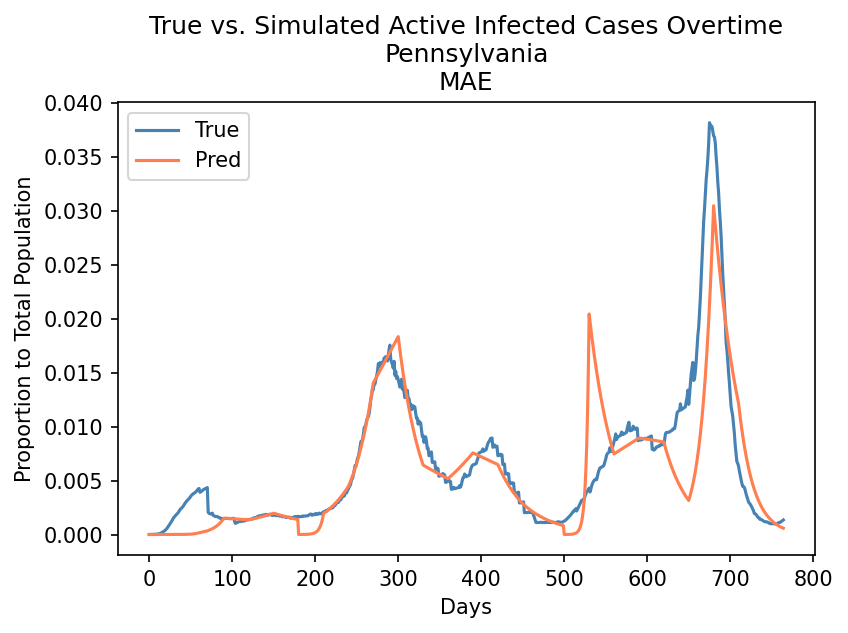

In [39]:
fig, ax = plt.subplots(dpi=150)
ax.plot(range(len(I_pa_mae)), PA_data[:-1], label="True", color='steelblue', alpha=1)
ax.plot(range(len(I_pa_mae)), I_pa_mae / N_PA, label="Pred", color='coral')
plt.xlabel("Days")
plt.ylabel("Proportion to Total Population")
plt.title("True vs. Simulated Active Infected Cases Overtime\nPennsylvania\nMAE")
plt.legend()
plt.show()

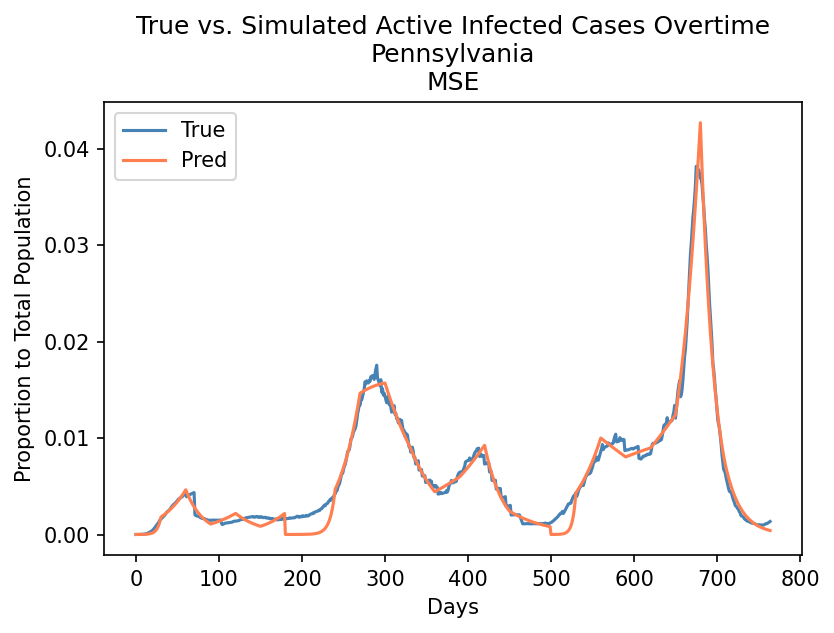

In [40]:
fig, ax = plt.subplots(dpi=150)
ax.plot(range(len(I_pa_mse)), PA_data[:-1], label="True", color='steelblue', alpha=1)
ax.plot(range(len(I_pa_mse)), I_pa_mse / N_PA, label="Pred", color='coral')
plt.xlabel("Days")
plt.ylabel("Proportion to Total Population")
plt.title("True vs. Simulated Active Infected Cases Overtime\nPennsylvania\nMSE")
plt.legend()
plt.show()

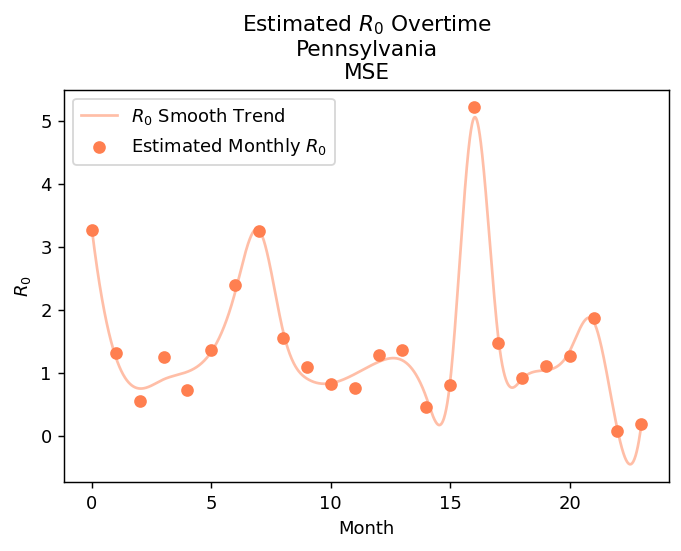

In [42]:
spl = UnivariateSpline(list(range(len(est_r0_pa_mse))), est_r0_pa_mse, k=3)
spl.set_smoothing_factor(0.5)
full_period = np.linspace(0, 23, 2000)
smoothed_est_r0 = spl(full_period)

fig, ax = plt.subplots(dpi=130)
ax.scatter(range(len(est_r0_pa_mse)), est_r0_pa_mse, color="coral", label="Estimated Monthly $R_0$")
ax.plot(full_period, smoothed_est_r0, color="coral", label="$R_0$ Smooth Trend", alpha=0.5)
plt.xlabel("Month")
plt.ylabel("$R_0$")
# plt.ylim(0,10)
plt.title("Estimated $R_0$ Overtime\nPennsylvania\nMSE")
plt.legend()
plt.show()

In [43]:
est_r0_pa_mse

array([3.26957793, 1.31260971, 0.54381801, 1.2516531 , 0.71586851,
       1.35348459, 2.38583677, 3.244822  , 1.5437235 , 1.08970912,
       0.82070224, 0.74749673, 1.27185563, 1.36604341, 0.4586323 ,
       0.81060145, 5.21211183, 1.46422028, 0.91349547, 1.11085597,
       1.25572025, 1.86174465, 0.07391794, 0.1858635 ])